In [1]:
import tp_knn_source as tpknn
import numpy as np
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

/home/thomas/.local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Génération artificielle de données

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les visualiser facilement) à savoir $p = 2$ dans le formalisme du sujet. On reprend en partie les jeux de données artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

## Question 1

Étudiez les fonctions `rand_bi_gauss`, `rand_tri_gauss`, `rand_clown et rand_checkers`. Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant
chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour `rand_checkers` générez
150 observations dans chaque classe ; pour `rand_tri_gauss` générez 50 observations dans chaque
classe, centrées en $(1, 1)^T$, $(−1, −1))^T$ et $(1, −1))^T$, tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [2]:
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = tpknn.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

In [3]:
n1 = 50
n2 = 50
sigmas1 = 1.
sigmas2 = 5.
X2, y2 = tpknn.rand_clown(n1, n2, sigmas1, sigmas2)

In [4]:
n1 = 150
n2 = 150
sigma = 0.1
X3, y3 = tpknn.rand_checkers(n1, n2, sigma)

In [5]:
n1 = 50
n2 = n1
n3 = n1
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
sigmas3 = [0.9, 0.9]
X4, y4 = tpknn.rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigmas1, sigmas2, sigmas3)

## Question 2

Utilisez la fonction `plot_2d` afin d’afficher les jeux de données générés avec chacune des fonctions.

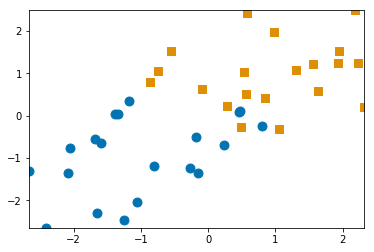

In [6]:
tpknn.plot_2d(X1, y1)

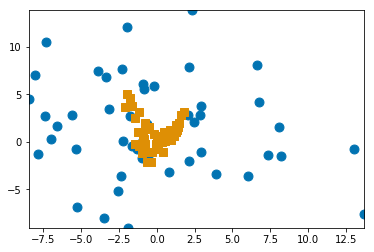

In [7]:
tpknn.plot_2d(X2, y2)

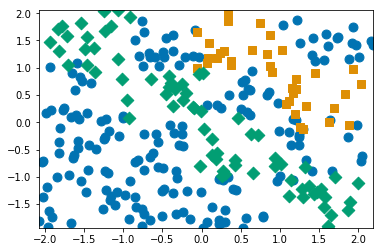

In [8]:
tpknn.plot_2d(X3, y3)

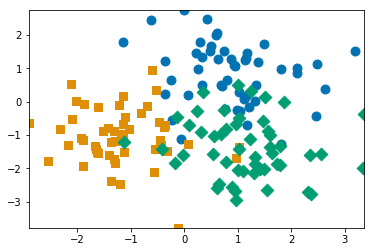

In [9]:
tpknn.plot_2d(X4, y4)

# K-plus proches voisins

## Approche intuitive
L’algorithme des $k$-plus proches voisins ($k$-nn : pour *k-nearest neighbors* en anglais) est un algorithme intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque d’étiquettes.

Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point $x$ on commence par déterminer l’ensemble de ses $k$-plus proches voisins parmi les points d’apprentissage que l’on note $V_k(x)$ (bien sûr on doit choisir $1 \leq k \leq n$ pour que cela ait un sens). La classe que l’on affecte au nouveau point $x$ est alors la classe majoritaire dans l’ensemble $V_k(x)$. Une illustration de la méthode est donnée en Figure 1 pour le cas de trois classes.

### Question 3

Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations $y$ sont à valeurs réelles : $Y = \mathbb{R}$.

## Approche formelle

### Question 4

Écrivez votre propre classe `KNNClassifier` avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans $V_k(x)$. Vérifier la validité des résultats en les comparant à ceux de la classe `KNeighborsClassifier` de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test). Vous pouvez utilisez le bloc de code ci-dessous en complétant le méthodes proposées. Pour plus d’information sur les classes on peut consulter par exemple http://docs.python.org/3/tutorial/classes.html.

In [39]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    n_neightbors = 0
    X = np.matrix([[]])
    y = np.matrix([[]])
    """ Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def distance(self, x, y):
        return np.sqrt((x-y)@(x-y))

    def predict(self, x):
        distances = []
        for i in range(self.X.shape[0]):
            x_i = self.X[i]
            d = self.distance(x_i, x)
            distances.append([i, d])
        sorted_distances = sorted(distances, key=lambda d: d[1])
        k_distances = sorted_distances[:self.n_neighbors]
        k_labels = [self.y.item(k[0]) for k in k_distances]
        k_labels = np.matrix([k_labels])
        return stats.mode(k_labels.T)[0].item()


def split_data(X, y):
    return [
        X[::2],
        y[::2],
        X[1::2],
        y[1::2],
    ]


def test_algo(X, y, k):
    my_predictions = []
    scikit_predictions = []
    X_train, y_train, X_test, y_test = split_data(X, y)
    scikit_knn = KNeighborsClassifier(n_neighbors=k)
    scikit_knn.fit(X_train, y_train)
    my_knn = KNNClassifier(k).fit(X_train, y_train)
    print(y_test.shape, y_train.shape, y2.shape)
    for i in range(y_test.shape[0]):
        my_predictions.append(my_knn.predict(X_test[i]))
        
    scikit_predictions.append(scikit_knn.predict(X_test))
    return [my_predictions, scikit_predictions[0]]

my_preds, scikit_preds = test_algo(X2, y2, 3)
print(my_preds)
print(scikit_preds)
print(my_preds - scikit_preds)

(50,) (50,) (100,)
[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0]
[-1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1.
 -1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [18]:
#

a = np.array([[0], [1], [2], [3]])
b = np.array([0, 0, 1, 1])
X_train, y_train, X_test, y_test = split_data(X2, y2)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 
neigh.predict([X_test[1]])

array([1.])

In [12]:
my_preds, scikit_preds = test_algo(X2, y2, 3)
print(my_preds)
print(scikit_preds)

(50,)


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
scikit_knn1 = KNeighborsClassifier(n_neighbors=5).fit(X1, y1)
def f1(vec):
    return scikit_knn1.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f1, X1, y1)

In [ ]:
scikit_knn2 = KNeighborsClassifier(n_neighbors=5).fit(X2, y2)
def f2(vec):
    return scikit_knn2.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f2, X2, y2)

In [ ]:
scikit_knn3 = KNeighborsClassifier(n_neighbors=5).fit(X3, y3)
def f3(vec):
    return scikit_knn3.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f3, X3, y3)

In [ ]:
scikit_knn4 = KNeighborsClassifier(n_neighbors=5).fit(X4, y4)
def f4(vec):
    return scikit_knn4.predict(vec.reshape(1, -1))
tpknn.frontiere_new(f4, X4, y4)